# Assignment 4
### Do three of four.

### Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

In [1]:
import pandas as pd
import numpy as np

ds_minnesota = pd.read_csv('mn_police_use_of_force.csv')
ds_tuna = pd.read_csv('tuna.csv')
ds_nhanes = pd.read_csv('nhanes_data_17_18.csv')

/var/folders/s1/mlm3ymrd1w9b7q_x0lh2mksm0000gn/T/ipykernel_96074/2964890562.py:6: DtypeWarning: Columns (142) have mixed types. Specify dtype option on import or set low_memory=False.
  ds_nhanes = pd.read_csv('nhanes_data_17_18.csv')


### Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data. Pick a variable and a statistic to compute (e.g. mean, median, variance, IQR)
- Use the `simulate` function from class to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

In [4]:
ds_nhanes.head()


,SEQN,GeneralHealthCondition,EverBreastfedOrFedBreastmilk,AgeStoppedBreastfeedingdays,AgeFirstFedFormuladays,AgeStoppedReceivingFormuladays,AgeStartedOtherFoodbeverage,AgeFirstFedMilkdays,TypeOfMilkFirstFedWholeMilk,TypeOfMilkFirstFed2Milk,...,DaysSmokedCigsDuringPast30Days,AvgCigarettesdayDuringPast30Days,TriedToQuitSmoking,TimesStoppedSmokingCigarettes,HowLongWereYouAbleToStopSmoking,UnitOfMeasureDayweekmonthyear_2_SMQ,CurrentSelfreportedHeightInches,CurrentSelfreportedWeightPounds,TriedToLoseWeightInPastYear,TimesLost10LbsOrMoreToLoseWeight
0,93703.0,NaN,1.0,273.0,1.0,365.0,152.0,365.0,Whole or regular milk,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,93704.0,NaN,1.0,60.0,3.0,365.0,126.0,365.0,Whole or regular milk,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,93705.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,165.0,0.0,11 times or more
3,93706.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,145.0,0.0,Never
4,93707.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
import matplotlib.pyplot as plt

PREFERRED_ORDER = ["BMXBMI", "RIDAGEYR", "BMXWT", "BMXHT", "BPXSY1", "BPXDI1"]  # edit as you like

def choose_numeric_var(dataframe, preferred=PREFERRED_ORDER):
    # Try preferred list first
    for col in preferred:
        if col in dataframe.columns and pd.api.types.is_numeric_dtype(dataframe[col]):
            # Avoid obvious IDs if possible (SEQN)
            if col.lower() not in ["seqn", "id"]:
                return col
    # Else pick first numeric column that doesn't look like an ID
    numeric_cols = [c for c in dataframe.select_dtypes(include="number").columns]
    for c in numeric_cols:
        if not any(tok in c.lower() for tok in ["seqn", "id"]):
            return c
    # Fallback: any numeric column
    if numeric_cols:
        return numeric_cols[0]
    raise ValueError("No numeric columns found to bootstrap.")

VAR = choose_numeric_var(ds_nhanes)
x = ds_nhanes[VAR].dropna().astype(float)

# 3 Define statistics
def stat_mean(s: pd.Series) -> float:
    return float(np.mean(s))

def stat_median(s: pd.Series) -> float:
    return float(np.median(s))

def stat_iqr(s: pd.Series) -> float:
    q1, q3 = np.quantile(s, [0.25, 0.75])
    return float(q3 - q1)

# 4 simulate() from class
def simulate(var: str, data: pd.DataFrame, fcn, S: int = 2000, plot: bool = False) -> np.ndarray:
    """
    Bootstrap resampling:
      - Draw S bootstrap samples (with replacement) from data[var]
      - Compute fcn on each sample
      - Return the array of estimates
    """
    x = data[var].dropna().astype(float)
    estimates = np.array([fcn(x.sample(frac=1.0, replace=True)) for _ in range(S)])

    if plot:
        # Sampling distribution histogram
        plt.figure(figsize=(8,4))
        plt.hist(estimates, bins=30, density=True)
        plt.axvline(x=fcn(x), linestyle='--')
        plt.title(f"Bootstrap Sampling Distribution of {fcn.__name__} for {var}")
        plt.xlabel("Estimate"); plt.ylabel("Density")
        plt.show()

        # ECDF
        xs = np.sort(estimates)
        ys = np.arange(1, len(xs)+1)/len(xs)
        plt.figure(figsize=(8,4))
        plt.plot(xs, ys)
        plt.axvline(x=fcn(x), linestyle='--')
        plt.title(f"ECDF of Bootstrap Estimates ({fcn.__name__})")
        plt.xlabel("Estimate"); plt.ylabel("ECDF")
        plt.show()

    return estimates

# 5 interval(L, H, estimates)
def interval(L: float, H: float, estimates: np.ndarray) -> tuple[float, float]:
    """
    Percentile interval: returns the L and H quantiles of the bootstrap estimates.
    Example: L=0.05, H=0.95 -> 90% CI
    """
    if not (0.0 <= L < H <= 1.0):
        raise ValueError("Require 0 <= L < H <= 1")
    lo, hi = np.quantile(estimates, [L, H])
    return float(lo), float(hi)

# 6 Run the bootstrap

S = 50000            # number of bootstrap resamples
L, H = 0.05, 0.95   # 90% percentile CI

est_mean  = simulate(VAR, ds_nhanes, stat_mean,   S=S, plot=False)
est_median= simulate(VAR, ds_nhanes, stat_median, S=S, plot=False)
est_iqr   = simulate(VAR, ds_nhanes, stat_iqr,    S=S, plot=False)

ci_mean   = interval(L, H, est_mean)
ci_median = interval(L, H, est_median)
ci_iqr    = interval(L, H, est_iqr)

point_mean   = stat_mean(x)
point_median = stat_median(x)
point_iqr    = stat_iqr(x)

summary = pd.DataFrame({
    "Variable": [VAR, VAR, VAR],
    "Statistic": ["Mean", "Median", "IQR"],
    "Point Estimate": [point_mean, point_median, point_iqr],
    f"{int((H-L)*100)}% CI Lower ({L})": [ci_mean[0], ci_median[0], ci_iqr[0]],
    f"{int((H-L)*100)}% CI Upper ({H})": [ci_mean[1], ci_median[1], ci_iqr[1]],
    "Bootstrap Samples (S)": [S, S, S],
    "Non-missing n": [len(x), len(x), len(x)]
})

print(f"Chosen variable: {VAR!r} (non-missing n = {len(x)})\n")
print(summary.to_string(index=False))


Chosen variable: 'EverBreastfedOrFedBreastmilk' (non-missing n = 1069)

                    Variable Statistic  Point Estimate  89% CI Lower (0.05)  89% CI Upper (0.95)  Bootstrap Samples (S)  Non-missing n
EverBreastfedOrFedBreastmilk      Mean        0.806361             0.786717             0.826006                  50000           1069
EverBreastfedOrFedBreastmilk    Median        1.000000             1.000000             1.000000                  50000           1069
EverBreastfedOrFedBreastmilk       IQR        0.000000             0.000000             0.000000                  50000           1069


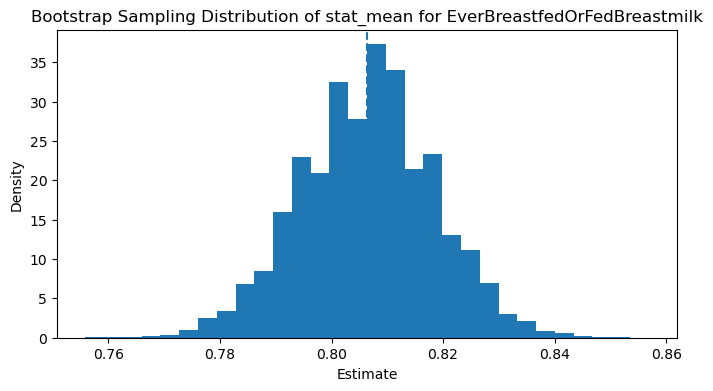

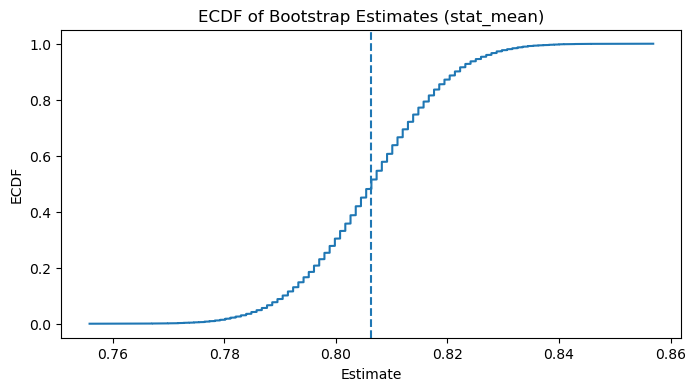

Variable: 'EverBreastfedOrFedBreastmilk'  (non-missing n = 1069)
Point estimate (mean): 0.8064
89% percentile interval: (0.7867, 0.8260)


In [9]:
S_demo = 20000
try:
    VAR
except NameError:
    VAR = choose_numeric_var(ds_nhanes)

est_mean_demo = simulate(VAR, ds_nhanes, stat_mean, S=S_demo, plot=True)

L, H = 0.05, 0.95
ci_low, ci_high = interval(L, H, est_mean_demo)
print(f'Variable: {VAR!r}  (non-missing n = {len(ds_nhanes[VAR].dropna())})')
print(f'Point estimate (mean): {stat_mean(ds_nhanes[VAR].dropna()):.4f}')
print(f'{int((H-L)*100)}% percentile interval: ({ci_low:.4f}, {ci_high:.4f})')

### Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$, and make KDE plots of your results.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?